# Research Internship: GAN on Ellipsoids

In [7]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix under the following licence:

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Preliminaries

In [8]:
import tensorflow as tf
from keras import backend as K

import os
import time
import datetime
import numpy as np
from scipy import fft
import cv2

from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

from functions import concat_images

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Parameters

Parameters:
-----------

- N_tele: Number of telescopes. Is required, so the correct datasets can be loaded. 
- beta: Salt and Pepper noise percentage. Default: 0.005 
- BATCH_SIZE: Size of the batches, i.e. how many images are being trained together. Default: 1
- BUFFER_SIZE: Number of images in the training set. Default: 1400
- img_size: Dimensions of the images. Images must be quadratic. 
- learning_rate: Learning rate of the optimizers. 
- disc_train_iterations: How many iterations of discriminator-training before returning the generator-training. Default: 1
- filtersize: Size of the filters in the neural networks. . Default: 4
- run_training: Whether or not the training start. Turn off if you only want to display the results > Requires checkpoint_dir to a checkpoint. 

-> Directories are automatically selected based on parameters.

In [10]:
# Model parameters
N_tele = 4 
beta = 0.005 
BATCH_SIZE = 1
BUFFER_SIZE = 1400
img_size = 128 
learning_rate = 1e-5
disc_train_iterations = 2 
filtersize = 5

run_training = False 

# Directories of model and log outputs
PATH = "Data/LST-1/"
checkpoint_dir = "models/models/ellipsoids_run8.22_a0.005_b0.005_discrep1_it100k_bs1_lr2em4_teles4_addedlayers_filtersize5_LST/"

### Load Dataset

In [11]:
def load(image_file):
    """
    Loads the concatanated image files and separates them. 

    Input:
    ------
    image-file

    Output:
    ------
    Input image and ground truth image
    """
    
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]
    
    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [12]:
sample_input, sample_real = load(str(PATH+'train/ellipsoid_1000.jpg'))

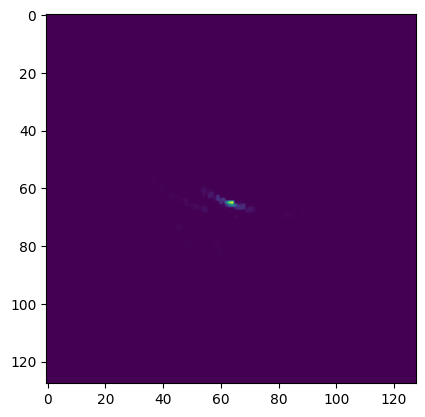

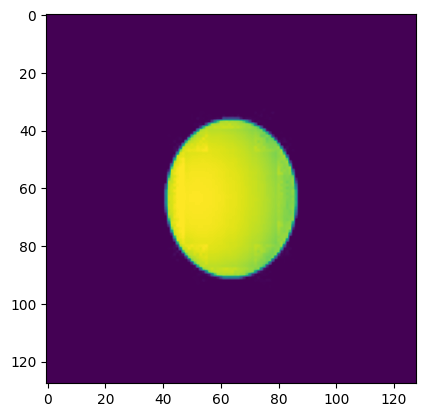

In [13]:
for element in [sample_input, sample_real]:
    plt.figure()
    plt.imshow(element)

### Preprocessing

In [14]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [15]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, img_size, img_size, 1])

    return cropped_image[0], cropped_image[1]

In [16]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [17]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing by 6.25%
    input_image, real_image = resize(input_image, real_image, int(img_size + img_size*0.0625), int(img_size + img_size*0.0625))

    # Random cropping back 
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

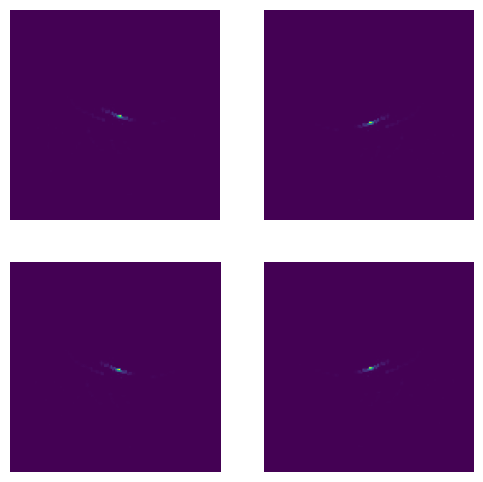

In [18]:
# Check if random_jitter works:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(sample_input, sample_real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp)# / 255.0)
    plt.axis('off')
plt.show()

## Helper functions

In [19]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [20]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   img_size, img_size)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [21]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '/train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [22]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH + '/test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH + '/val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Generator

In [23]:
OUTPUT_CHANNELS = 1

In [24]:
# Encoder (downsample):
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, data_format="channels_last",
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [25]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(tf.cast(sample_input, float), 0))
print (down_result.shape)

(1, 64, 64, 3)


In [26]:
# Decoder (upsample):
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    data_format="channels_last",
                                    use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [27]:
up_model = upsample(3, 4, apply_dropout=True)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [28]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[img_size, img_size, 1]) # Example shape: (batch_size, 128, 128, 1)

    # Note: If changing image_size, you might want to remove the last layer in down_stack and the first layer in up_stack!
    
    down_stack = [
        downsample(64, filtersize, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, filtersize),  # (batch_size, 32, 32, 128)
        downsample(256, filtersize),  # (batch_size, 16, 16, 256)
        downsample(512, filtersize),  # (batch_size, 8, 8, 512)
        downsample(512, filtersize),  # (batch_size, 4, 4, 512)
        downsample(512, filtersize),  # (batch_size, 2, 2, 512)
        downsample(512, filtersize),  # (batch_size, 1, 1, 512)
        #downsample(512, 4), # (batch_size, 1, 1, 512)

    ]

    up_stack = [
        #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, filtersize, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, filtersize, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, filtersize),  # (batch_size, 16, 16, 1024)
        upsample(256, filtersize),  # (batch_size, 32, 32, 512)
        upsample(128, filtersize),  # (batch_size, 64, 64, 256)
        upsample(64, filtersize),  # (batch_size, 128, 128, 128)
    ]
    

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, filtersize,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs


    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


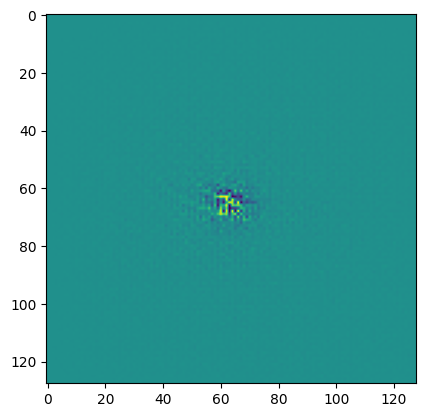

In [30]:
# Test generator
gen_output = generator(sample_input[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator loss

In [31]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # either 0 or 1
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output+0.0)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Discriminator 

In [32]:
# Define Salt-and-Pepper noise function
def Saltandpepper(image, prob, display_img=False):
    """
    Add salt and pepper noise to image
    prob: Probability of the noise
    """
    # If displaying images:
    if display_img:
        random_values = tf.random.uniform(shape=image.shape)
    else:
        random_values = tf.random.uniform(shape=image[0,:,:,:].shape)

    image = tf.where(random_values < (prob/2), 127., image)
    image = tf.where(1 - random_values < (prob/2), 0., image)
    
    return image


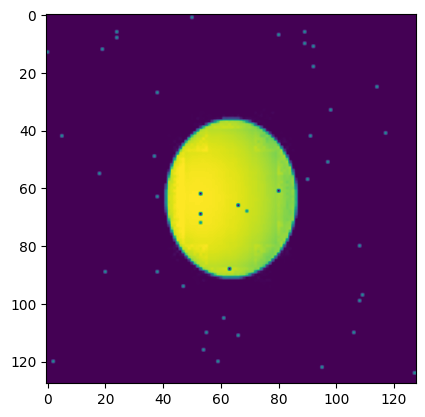

In [33]:
plt.imshow(Saltandpepper(sample_real, beta, display_img=True))

In [34]:
def Discriminator():
    """
    Discriminator in this GAN. 

    In case you want to use 64x64px, you might want to remove down3 for better images. 
    """
    
    initializer = tf.random_normal_initializer(0., 0.02)

    inp_ = tf.keras.layers.Input(shape=[img_size, img_size, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[img_size, img_size, 1], name='target_image')

    # Add Salt-and-Pepper noise to the input
    inp = Saltandpepper(inp_, beta)

    x = tf.keras.layers.concatenate([inp, tar])


    down1 = downsample(32, filtersize, False)(x)
    down2 = downsample(64, filtersize)(down1)
    down3 = downsample(128, filtersize)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(256, filtersize, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, filtersize, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [35]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


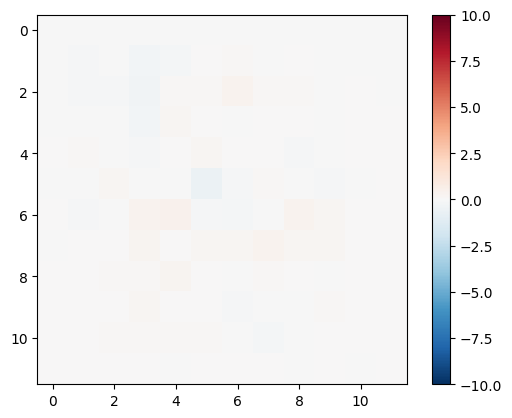

In [36]:
# Test discriminator
disc_out = discriminator([sample_input[tf.newaxis, :], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()

### Disciminator loss

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

## Optimizer

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

In [39]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

In [40]:
def ff2d_difference(image1, image2, sampling=False):
    """
    Calculates the difference between two images in the Fourier Plane. 
    Input: 2 Images
    Output: Absolute difference between Fourier-Shifted 2D FFT
    """

    # What should come first????

    image1_fft = np.abs(fft.fftshift(fft.fft2(fft.fftshift(image1))))
    image2_fft = np.abs(fft.fftshift(fft.fft2(fft.fftshift(image2))))

    '''
    if sampling:
        sampling_mask = np.load(f"Data/masks/{img_size}px/MASK_{N_tele}_telescopes.npy")

        image1_fft = np.multiply(image1_fft, sampling_mask)
        image2_fft = np.multiply(image2_fft, sampling_mask)
    '''

    output = (image1_fft - image2_fft)
    
    if sampling:
        sampling_mask = np.load(f"Data/masks/{img_size}px/MASK_{N_tele}_telescopes.npy")
        output = np.multiply(output, sampling_mask)
    
    return output


In [41]:
def optional_rotation(prediction, groundtruth):
    """
    Check whether the predicted image or its 180° rotation is closer to the ground truth.
    Algorithm used: Mean Squared Error (MSE)
    Input: predicted image, ground_truth image
    Output: Either predicted image or its 180° rotation
    """

    # Normalize output and extract shape=(img_size, img_size)
    prediction = prediction*0.5 + 0.5
    prediction_rot = prediction[0,::-1,::-1,0]
    prediction = prediction[0,:,:,0]
    groundtruth = groundtruth[0,:,:,0]

    # Calculate MSE
    diff_pred = cv2.subtract(np.array(prediction), np.array(groundtruth))
    mse_pred = np.sum(diff_pred**2)/float(img_size**2)

    diff_rot = cv2.subtract(np.array(prediction_rot), np.array(groundtruth))
    mse_rot = np.sum(diff_rot**2)/float(img_size**2)

    if mse_rot < mse_pred:
        return prediction_rot
    else:
        return prediction


In [42]:
def generate_images(model, test_input, target, show_diff = False, sampling = False, save_images = False, counter=None):
    """
    Plots four images based on the model: Input, Prediction, Ground truth and (optionally) difference in the fourier plane.  
    Also checks, whether the image or its rotation is closer to the ground truth. 

    If sampling is provided, the PATH of the mask must be specified globally. 
    If save_images is provided, counter must also be provided. 

    Parameters:
    -----------
    show_diff: boolean
        Whether the difference should be displayed.
    sampling: boolean
        Whether the sparse sampling (based on a mask) should be applied. 
    save_images: boolean
        Whether some images should be saved. 

    Returns:
    --------
    None
    """

    prediction = model(test_input, training=True)
    if show_diff:
        plt.figure(figsize=(15, 3))
    else:
        #plt.figure(figsize=(12,5))
        pass

    # Check wheter the image is rotated by 180 degrees or not and normalize to [-1, 1]
    prediction = optional_rotation(prediction, target) # shape=(128, 128)

    if show_diff:
        # Calculate difference and normalize to [-1, 1]
        difference = ff2d_difference(target[0,:,:,0], prediction, sampling=sampling)
        difference = (2*((difference - np.min(difference))/(np.max(difference) - np.min(difference))) -1)
        
        display_list = [test_input[0,:,:,0], target[0,:,:,0], prediction, difference]
        title = ['Input Image', 'Ground Truth', 'Predicted Image', 'Difference']
        N_images = 4
    else:
        display_list = [test_input[0], target[0], prediction]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        N_images = 3

    
    # Plot the results

    if save_images:
        plt.figure(figsize=(10,6))
        plt.rcParams['font.size'] = 15
        display_list = [target[0], prediction]
        title = ['Ground Truth', 'Generated Image']
        N_images = 2
        
    for i in range(N_images):
        plt.subplot(1, N_images, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot:
        plt.imshow(display_list[i]* 0.5 + 0.5)
        plt.axis('off')

    # Save the plots
    if save_images:
        if counter == None:
            raise Warning("You do not have a counter. Images will be overwritten and NOT be saved.")
       
        plot_name = f"Data/Plots/{checkpoint_dir.split('/')[2:-1][0]}/image_{counter}"
        
        if counter == 0:
            if not os.path.exists(f"{plot_name[:-8]}"):
                os.makedirs(f"{plot_name[:-8]}")
                print(f"{plot_name[:-8]} created.")
    
        plt.savefig(f"{plot_name}.pdf", format='pdf', bbox_inches='tight')
        plt.savefig(f"{plot_name}.png")
        
    plt.show()

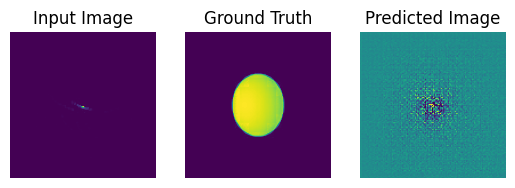

In [43]:
example_input = sample_input[tf.newaxis, :]
example_target = sample_real[tf.newaxis, :]

generate_images(generator, example_input, example_target)

## Training

In [44]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime(f"%Y%m%d-%H%M%S_{checkpoint_dir[9:]}"))

In [45]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))


    # Loop over discriminator separately -> increases relative training of discriminator
    for i in range(disc_train_iterations):
        with tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [46]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [47]:
if run_training:
    fit(train_dataset, test_dataset, steps=3000)

## Restore old checkpoints

In [48]:
print(tf.train.latest_checkpoint(checkpoint_dir))

models/models/ellipsoids_run8.22_a0.005_b0.005_discrep1_it100k_bs1_lr2em4_teles4_addedlayers_filtersize5_LST/ckpt-20


In [49]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate images with test set

Data/Plots/ellipsoids_run8.22_a0.005_b0.005_discrep1_it100k_bs1_lr2em4_teles4_addedlayers_filtersize5_LST created.


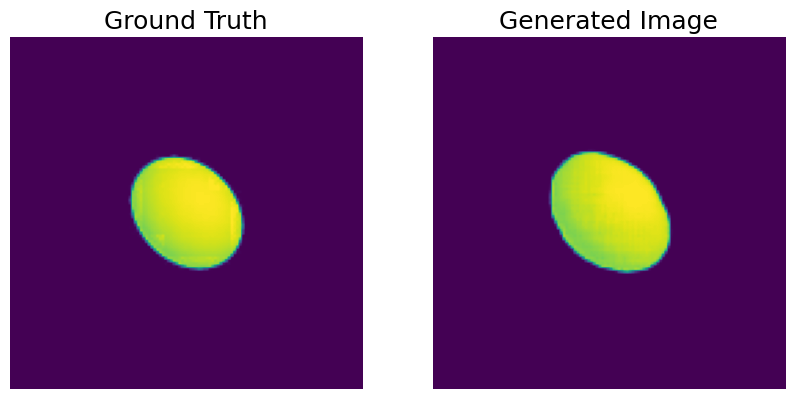

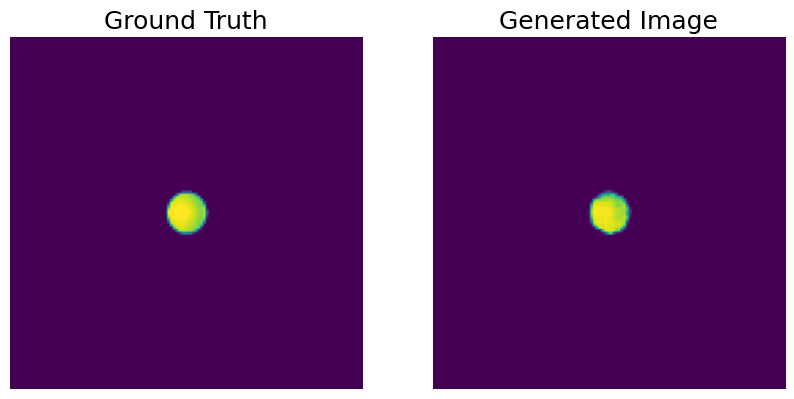

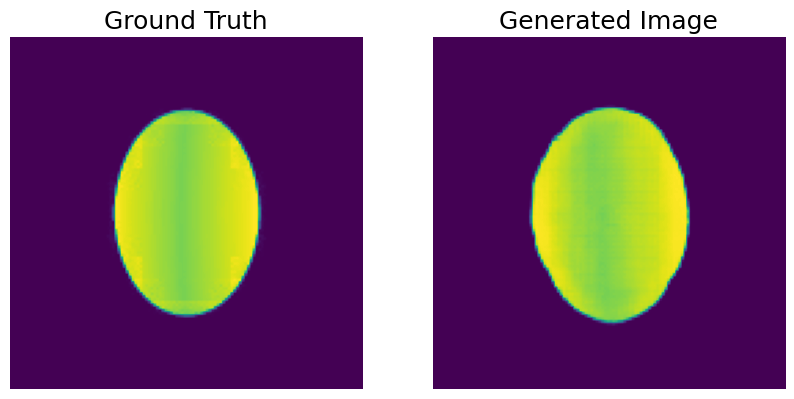

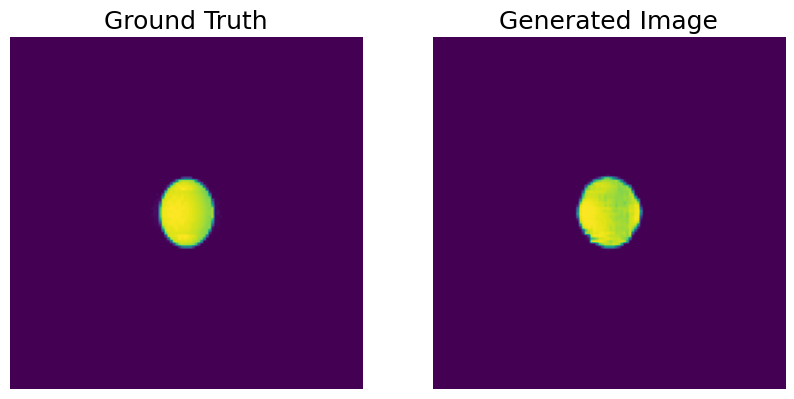

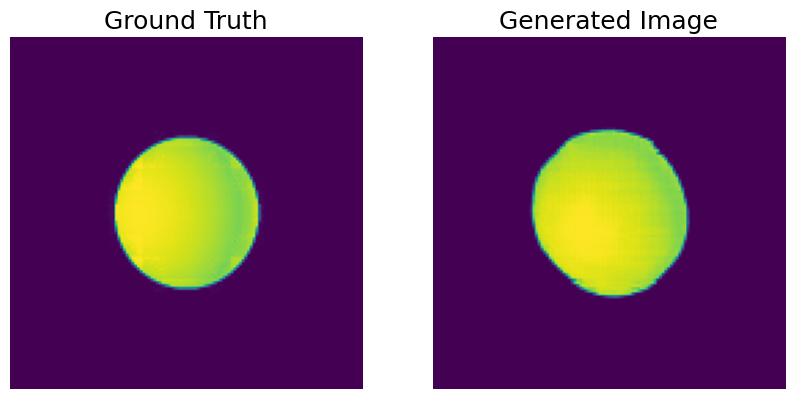

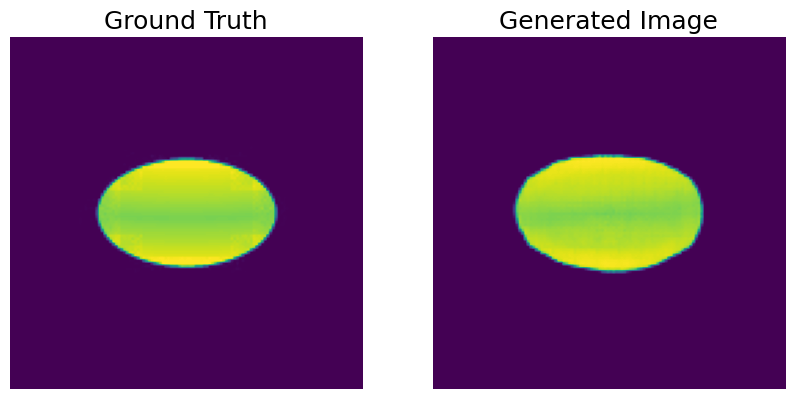

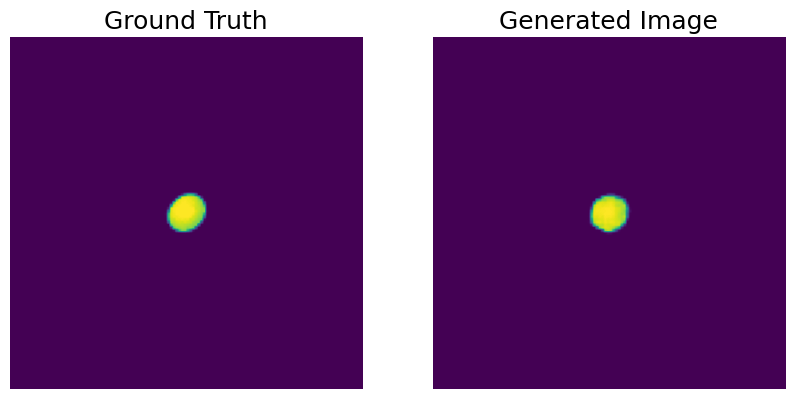

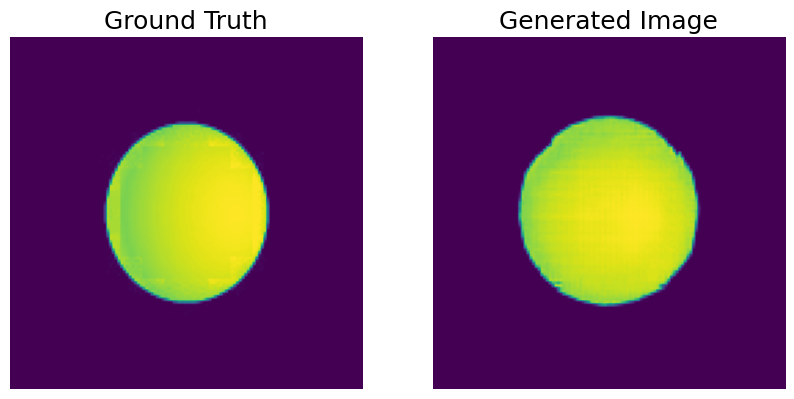

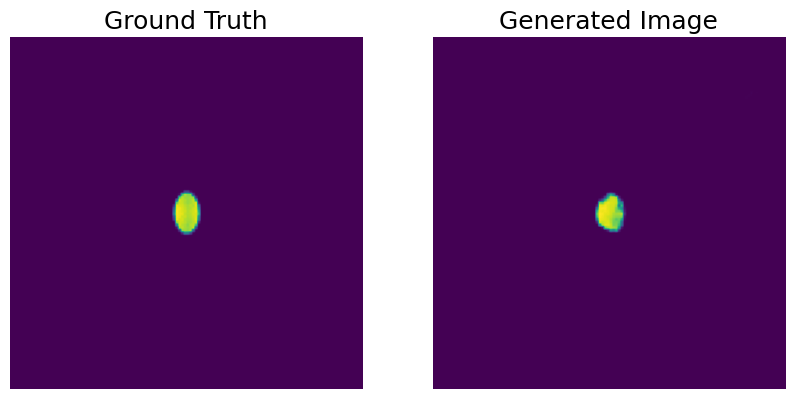

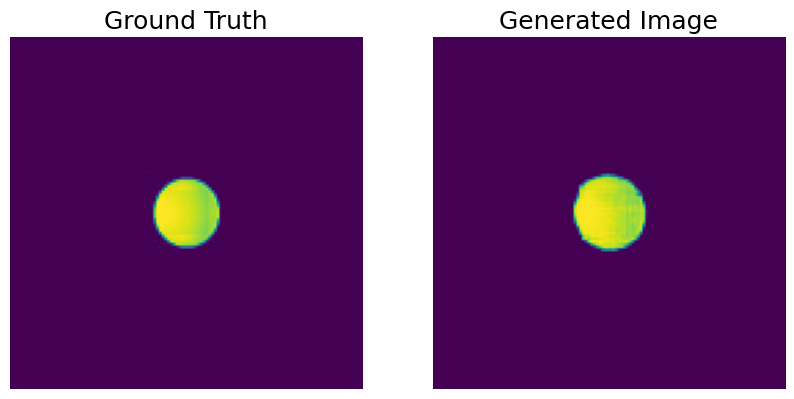

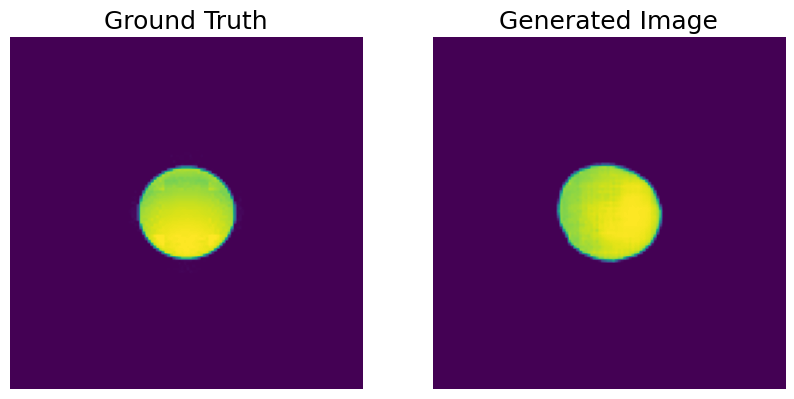

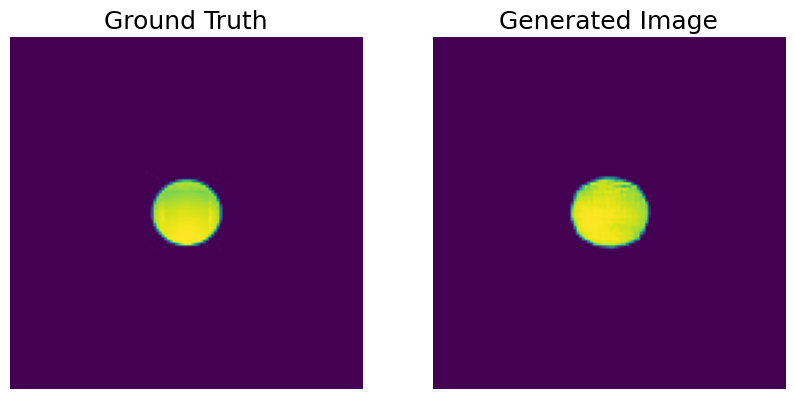

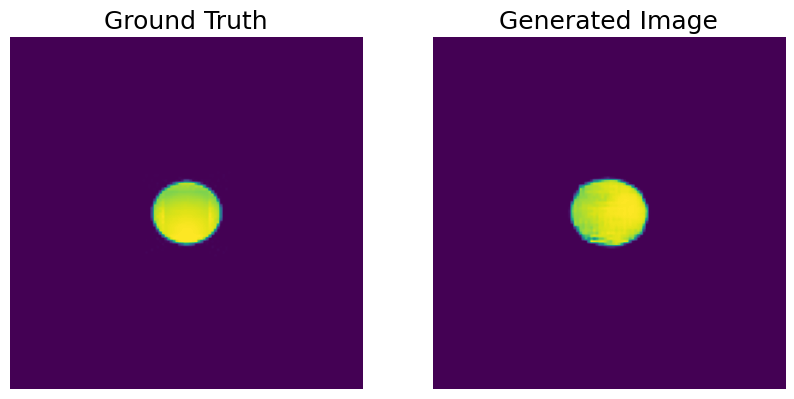

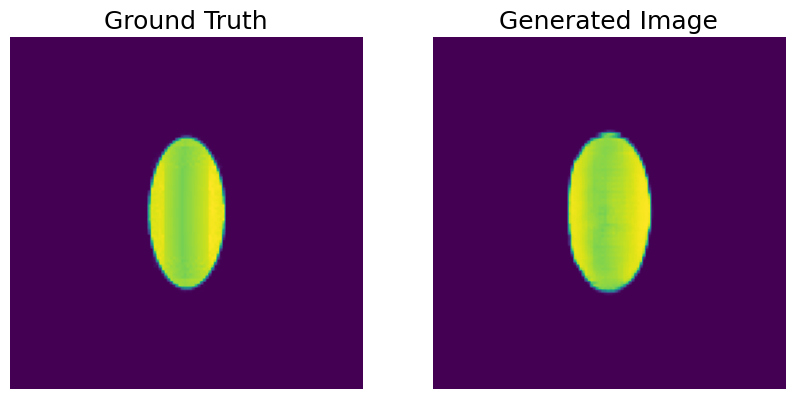

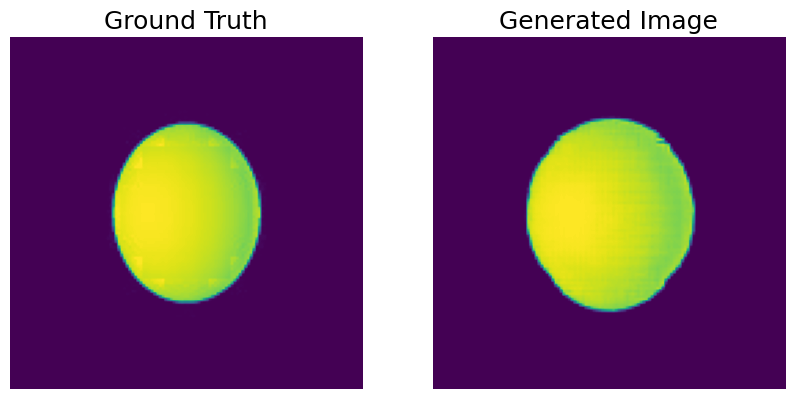

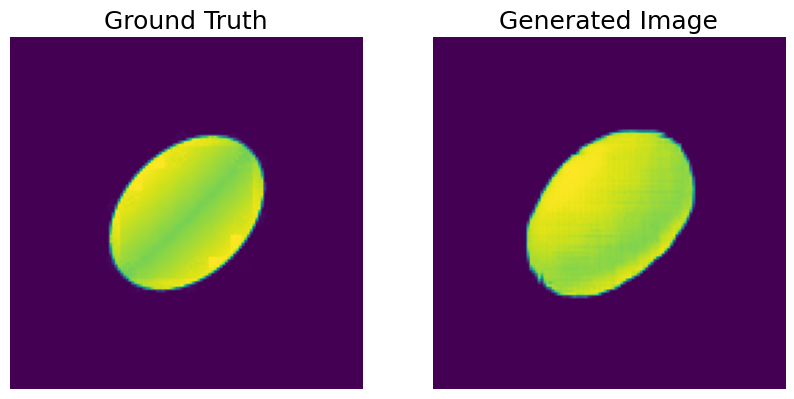

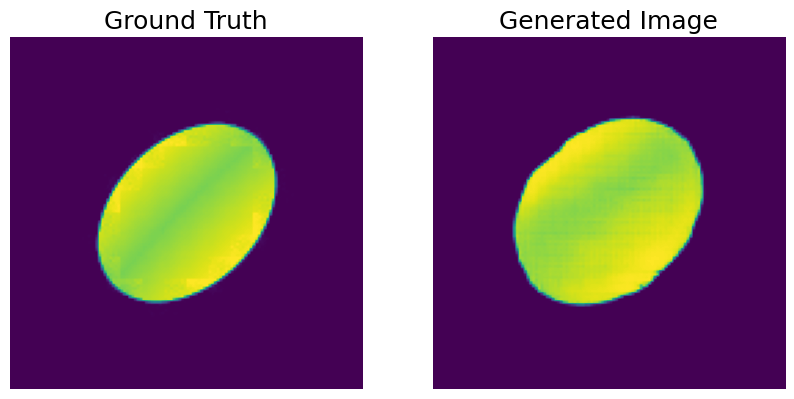

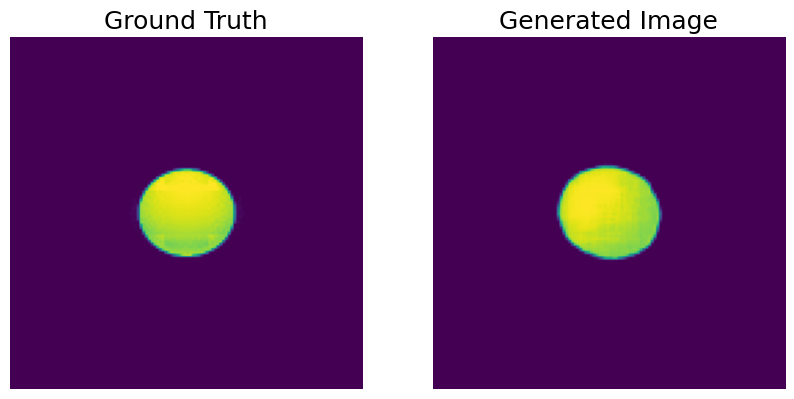

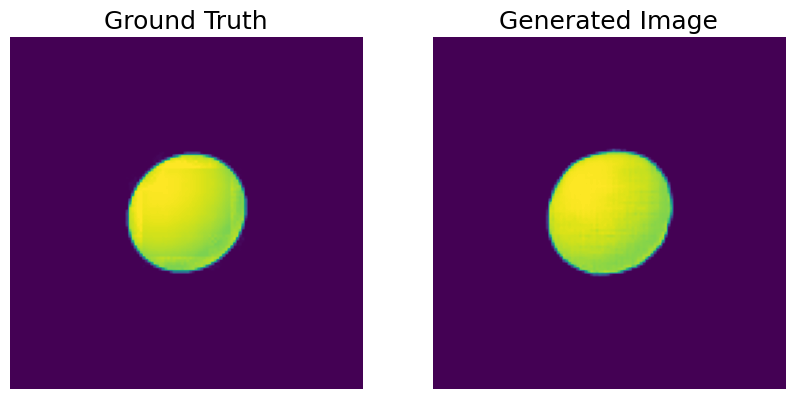

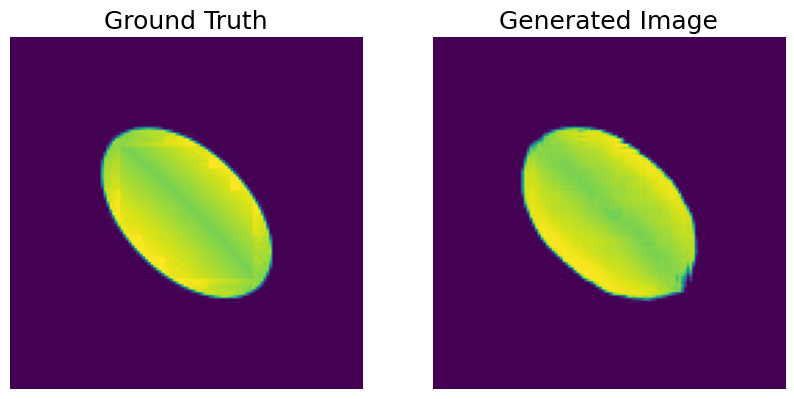

In [50]:
counter = 0
for inp, tar in test_dataset.take(20):
    generate_images(generator, inp, tar, show_diff=False, sampling=False, save_images=True, counter=counter)
    counter += 1

# Run the trained model on a few examples from the test set
i = 0
for inp, tar in test_dataset.take(2):
    img_filename = checkpoint_dir.split('/')[-2] + f"_{i}.png"
    generate_images(generator, inp, tar)
    
    save_result(inp, tar, img_filename)
    i += 1